<h1><center>CS501 - Final Project - Product Reviews Analysis</center></h1>

#  Project Scope:

The main goal of this project is to perform advanced analysis on product reviews using data analytics methods and machine learning algorithms. Amazon product reviews will be used as a case study. The final outcomes of this project are:

Perform data cleaning.

1. Apply some data exploration methods to get some initial insights about the data.
2. Train a classifier model to perform sentimental analysis.
3. Use pre-trained deep learning model (Bert) to perform sentimental analysis.
4. Compare both methods.
5. Extract useful insights from the sentimental analysis to help understand the quality/issues/satisfaction of a specific product.
6. If time permits, a QA method will be used to help users quickly explore/search information in reviews of a specific product.

### Dataset:
It is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users. In this project, only Appliances dataset is used to make the processing time faster. An example of a review is shwon below.

Example: <br>
{<br>
  "reviewerID": "A2SUAM1J3GNN3B",<br>
  "asin": "0000013714",<br>
  "reviewerName": "J. McDonald",<br>
  "helpful": [2, 3],<br>
  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",<br>
  "overall": 5.0,<br>
  "summary": "Heavenly Highway Hymns",<br>
  "unixReviewTime": 1252800000,<br>
  "reviewTime": "09 13, 2009"<br>
}<br>

Link: https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/

## Import dependencies and libraries

In [24]:
import pandas as pd
import numpy as np
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import json
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from statistics import mean 
import torch

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nordine.quadar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Part 1 - Data preparation

#### In this section, we apply data pre-processing by cleaning the dataset and correcting data types.

In [26]:
# Data loader 

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Appliances.json.gz')

In [27]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5.0,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5.0,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5.0,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5.0,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN


In [28]:
# Keeping only review with more than 100 reviews
asin_tot_rev = df.groupby('asin')['reviewerID'].nunique()
asin_tot_rev =asin_tot_rev[asin_tot_rev > 100]
data = df[df.asin.isin(asin_tot_rev.index)]

In [29]:
data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
58,5.0,30,False,"12 9, 2007",A2UAX5WTHHKBBF,B00004YWK2,NaN,Mark S. Holden,This allows you to switch from venting your dr...,A wonderful idea.,1197158400,NaN
59,3.0,NaN,True,"06 6, 2017",A2DHQKNGSYEHLS,B00004YWK2,NaN,Radek,The bands are quite useless.\nThe mesh is not ...,Three Stars,1496707200,NaN
60,4.0,NaN,True,"03 14, 2017",AZ1F62XGI25RS,B00004YWK2,NaN,Jocivus lopez,This was just what I was looking for. The serv...,The service and price were very good. It works...,1489449600,NaN
61,5.0,NaN,True,"03 13, 2017",A2G1T9MVZLOHNG,B00004YWK2,NaN,Poodlehead,Works great!,Five Stars,1489363200,NaN
62,5.0,NaN,True,"03 10, 2017",A17109KS0DCTOG,B00004YWK2,NaN,roger erwin,It is a good .put the heat in my house when ne...,It is a good. put the heat in my house when ne...,1489104000,NaN


In [30]:
# dropping non necessary column
data = data.drop(['style','reviewerName','image','reviewTime'], axis=1)

In [31]:
# converting to the right data type
data['vote'] = data['vote'].str.replace(',', '').astype(float)
data['vote'] = data['vote'].fillna(0)
data['vote'] = data['vote'].astype(int)
data['overall'] = data['overall'].astype(int)
data['unixReviewTime'] = pd.to_datetime(data['unixReviewTime'],unit='s')
data['reviewText'] = data['reviewText'].astype(str)
# data['reviewText'] = data['reviewText'].str.replace('\', '').astype(float)
data['verified'] = data['verified'].replace({True: 'Yes', False: 'No'})
# drop nan rows
data.dropna()

,overall,vote,verified,reviewerID,asin,reviewText,summary,unixReviewTime
58,5,30,No,A2UAX5WTHHKBBF,B00004YWK2,This allows you to switch from venting your dr...,A wonderful idea.,2007-12-09
59,3,0,Yes,A2DHQKNGSYEHLS,B00004YWK2,The bands are quite useless.\nThe mesh is not ...,Three Stars,2017-06-06
60,4,0,Yes,AZ1F62XGI25RS,B00004YWK2,This was just what I was looking for. The serv...,The service and price were very good. It works...,2017-03-14
61,5,0,Yes,A2G1T9MVZLOHNG,B00004YWK2,Works great!,Five Stars,2017-03-13
62,5,0,Yes,A17109KS0DCTOG,B00004YWK2,It is a good .put the heat in my house when ne...,It is a good. put the heat in my house when ne...,2017-03-10
...,...,...,...,...,...,...,...,...
602714,5,0,Yes,A3KT6VYTFH31SF,B01HICGMWC,"Great price, fit good,and look good.",Filters,2018-09-08
602715,5,0,Yes,A2XWTEPQL6FRZQ,B01HICGMWC,this is the first time ordering this filter an...,good filters,2018-09-08
602716,5,0,Yes,A2NXFZL0HTGJ78,B01HICGMWC,Thank you. Works great.,Thank you,2018-09-03
602717,5,0,Yes,A2NFUCM454QRF1,B01HICGMWC,Fits great with my Whirlpool refrigerator. Kee...,Highly recommend,2018-08-31


In [32]:
data.dtypes

overall                    int32
vote                       int32
verified                  object
reviewerID                object
asin                      object
reviewText                object
summary                   object
unixReviewTime    datetime64[ns]
dtype: object

### New Metadata:
reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

asin - ID of the product, e.g. 0000013714

vote - helpful votes of the review

verified - verified purchase

reviewText - text of the review

overall - rating of the product

summary - summary of the review

unixReviewTime - time of the review (unix time)


In [33]:
data.head()

,overall,vote,verified,reviewerID,asin,reviewText,summary,unixReviewTime
58,5,30,No,A2UAX5WTHHKBBF,B00004YWK2,This allows you to switch from venting your dr...,A wonderful idea.,2007-12-09
59,3,0,Yes,A2DHQKNGSYEHLS,B00004YWK2,The bands are quite useless.\nThe mesh is not ...,Three Stars,2017-06-06
60,4,0,Yes,AZ1F62XGI25RS,B00004YWK2,This was just what I was looking for. The serv...,The service and price were very good. It works...,2017-03-14
61,5,0,Yes,A2G1T9MVZLOHNG,B00004YWK2,Works great!,Five Stars,2017-03-13
62,5,0,Yes,A17109KS0DCTOG,B00004YWK2,It is a good .put the heat in my house when ne...,It is a good. put the heat in my house when ne...,2017-03-10


In [34]:
# checking data
data['reviewText'][60]

'This was just what I was looking for. The service and price were very good. It works great.'

### Staring the cleaining process by removing punctuation, stop words and apply Stem / Lemmatize

In [35]:
# Load spacy
nlp = spacy.load('en_core_web_sm')

def clean_string(text, stem="None"):

    final_string = ""

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
#     text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

def partial_clean_string(text):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', '', text)
    
    final_string = text
    
    return final_string

In [36]:
data['reviewText_clean'] = data['reviewText'].apply(lambda x: partial_clean_string(x))
data['reviewText_deep_clean'] = data['reviewText'].apply(lambda x: clean_string(x, stem='Stem'))

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 368581 entries, 58 to 602718
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   overall                368581 non-null  int32         
 1   vote                   368581 non-null  int32         
 2   verified               368581 non-null  object        
 3   reviewerID             368581 non-null  object        
 4   asin                   368581 non-null  object        
 5   reviewText             368581 non-null  object        
 6   summary                368501 non-null  object        
 7   unixReviewTime         368581 non-null  datetime64[ns]
 8   reviewText_clean       368581 non-null  object        
 9   reviewText_deep_clean  368581 non-null  object        
dtypes: datetime64[ns](1), int32(2), object(7)
memory usage: 36.2+ MB


**Data type**
* Columns holding categorical data : Verfified and ASin 
* Columns holding continuous data: Overall and Vote

In [16]:
# Save cleaned data to csv file to save time next time
data.to_csv('Clean_data.csv', encoding='utf-8')

# Part 1 - Data Exploration

#### In this part, we explore dataset to get initial insights (correlation, outliers...) about the the numericl and categorical data and apply more cleaning if needed.

In [40]:
# dat = pd.read_csv('Clean_data.csv')
dat= data

In [41]:
dat.head()

,overall,vote,verified,reviewerID,asin,reviewText,summary,unixReviewTime,reviewText_clean,reviewText_deep_clean
58,5,30,No,A2UAX5WTHHKBBF,B00004YWK2,This allows you to switch from venting your dr...,A wonderful idea.,2007-12-09,this allows you to switch from venting your dr...,thi allow switch vent dryer outsid summer vent...
59,3,0,Yes,A2DHQKNGSYEHLS,B00004YWK2,The bands are quite useless.\nThe mesh is not ...,Three Stars,2017-06-06,the bands are quite useless.the mesh is not fi...,the band quit useless the mesh fine enough
60,4,0,Yes,AZ1F62XGI25RS,B00004YWK2,This was just what I was looking for. The serv...,The service and price were very good. It works...,2017-03-14,this was just what i was looking for. the serv...,thi i look the servic price good it work great
61,5,0,Yes,A2G1T9MVZLOHNG,B00004YWK2,Works great!,Five Stars,2017-03-13,works great!,work great
62,5,0,Yes,A17109KS0DCTOG,B00004YWK2,It is a good .put the heat in my house when ne...,It is a good. put the heat in my house when ne...,2017-03-10,it is a good .put the heat in my house when ne...,it good put heat hous need and need


In [11]:
dat.describe()

,Unnamed: 0,overall,vote
count,368581.000000,368581.000000,368581.000000
mean,242602.037718,4.332280,0.779332
std,147926.981986,1.246767,10.799358
min,58.000000,1.000000,0.000000
25%,113267.000000,4.000000,0.000000
50%,239893.000000,5.000000,0.000000
75%,369997.000000,5.000000,0.000000
max,602718.000000,5.000000,1913.000000


**Comment:** *By using the describe function on the selected column, we get the mean, std, min, max, 25th percentile, 50th percentile, and 75% percentile values of the columns.
We can see that the minimum number of vote in the dataset is 10 and max is 1913. Also we can tell that the very few reviews got votes as the 25%, 50% and 75% are equal to zero.

for the number of stars, we can tell that the more than 75% of the reviews have 5 stars.


**Five- Number Summary for the #stars:**

Q1 = 4

Q2 = median = 4.33

Q3 = 5

min= 1

max= 5

IQR = Q3 - Q1 = 5 - 4 = 1

<AxesSubplot:xlabel='overall', ylabel='Count'>

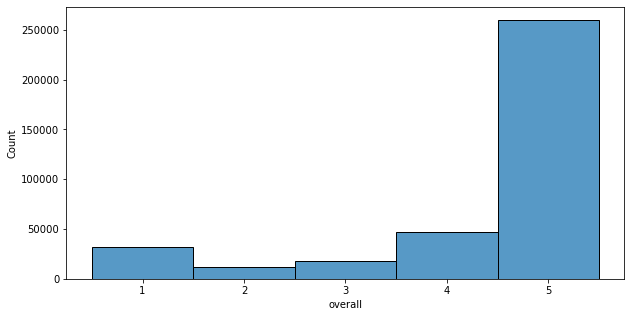

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(dat['overall'],discrete=True)

**Comment:** From the histogram above we confirm that the majority of reviews in the dataset have a 5 stars rating.

<AxesSubplot:xlabel='verified', ylabel='Count'>

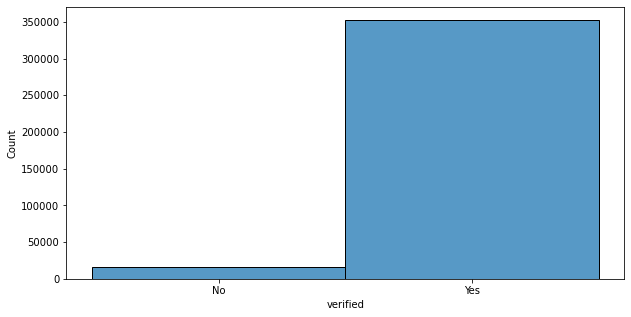

In [13]:
# dat['verified'] = dat['verified'].replace({True: 'Yes', False: 'No'})
plt.figure(figsize=(10,5))
sns.histplot(dat['verified'],discrete=True)

**Comment:** From the histogram above we can see that the majority of the reviews are coming from verified purchase which is good.

In [14]:
data.groupby([data['unixReviewTime'].dt.year.rename('year'), data['unixReviewTime'].dt.month.rename('month')]).agg({'count'})
rev_year = data.groupby([data['unixReviewTime'].dt.year.rename('year')]).agg({'count'})

NameError: name 'data' is not defined

In [22]:
dat['year'] = data['unixReviewTime'].dt.year
dat['month'] = data['unixReviewTime'].dt.month

<AxesSubplot:xlabel='year', ylabel='Count'>

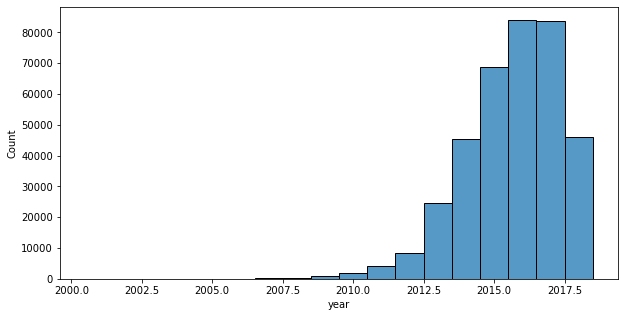

In [23]:
plt.figure(figsize=(10,5))
sns.histplot(dat['year'],discrete=True)

**Comment:** From the histogram above we can see that we start having reviews from 2012 and the majority were between 2015 and 2017. This can be explained by the fact that Amzon start getting success arounf 2012.

In [24]:
tab = pd.crosstab(data.year, data.overall, margins=False, values=data.overall, aggfunc=pd.Series.count)

<AxesSubplot:xlabel='year'>

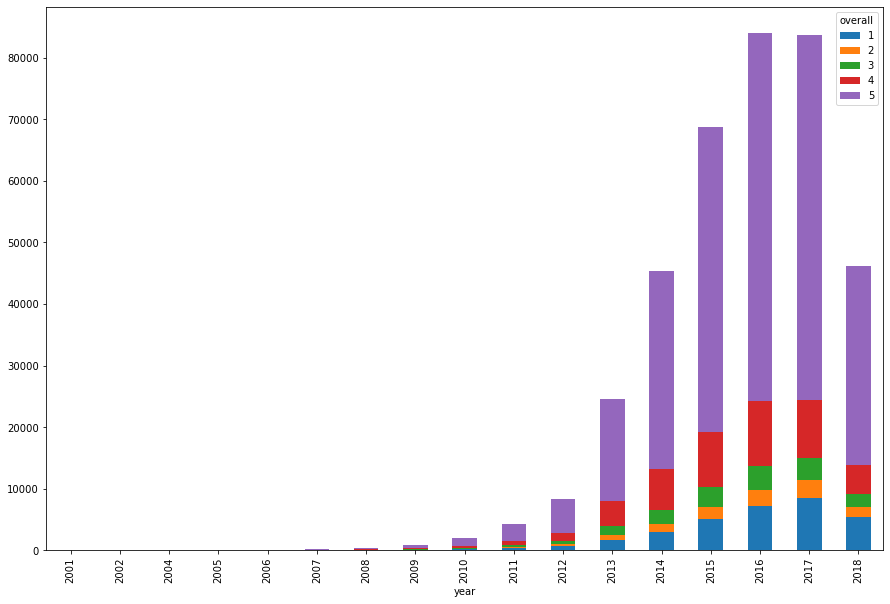

In [25]:
tab.plot.bar(stacked=True, figsize=(15,10))

<AxesSubplot:xlabel='year'>

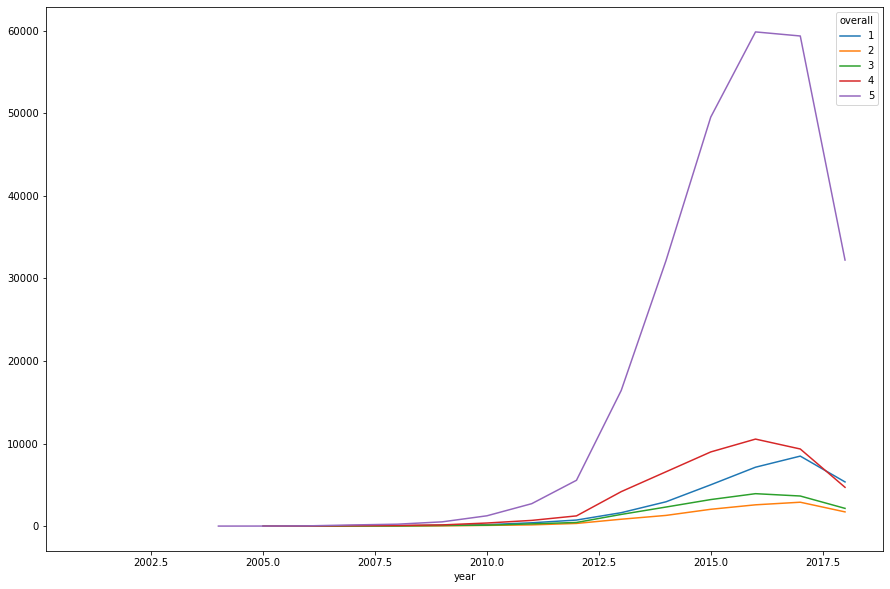

In [26]:
tab.plot(figsize=(15,10))

<AxesSubplot:xlabel='year'>

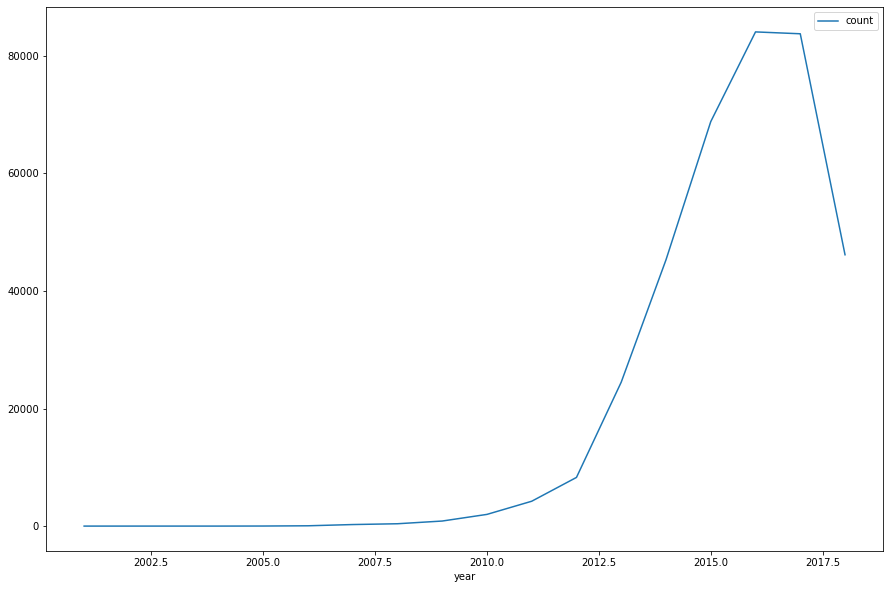

In [27]:
rev_year['overall'].plot(figsize=(15,10))

In [28]:
votes = dat.groupby(['overall'])['vote'].sum()

<AxesSubplot:xlabel='overall'>

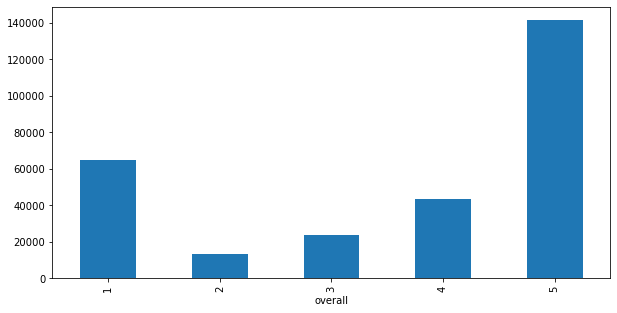

In [30]:
plt.figure(figsize=(10,5))
votes.plot.bar()

In [31]:
# Number of reviews per asin
asin_rev = dat.groupby(['asin'])['reviewText'].count()
asin_rev.describe()

count    1122.000000
mean      328.503565
std       425.687602
min       101.000000
25%       134.000000
50%       206.000000
75%       343.250000
max      6510.000000
Name: reviewText, dtype: float64

<AxesSubplot:>

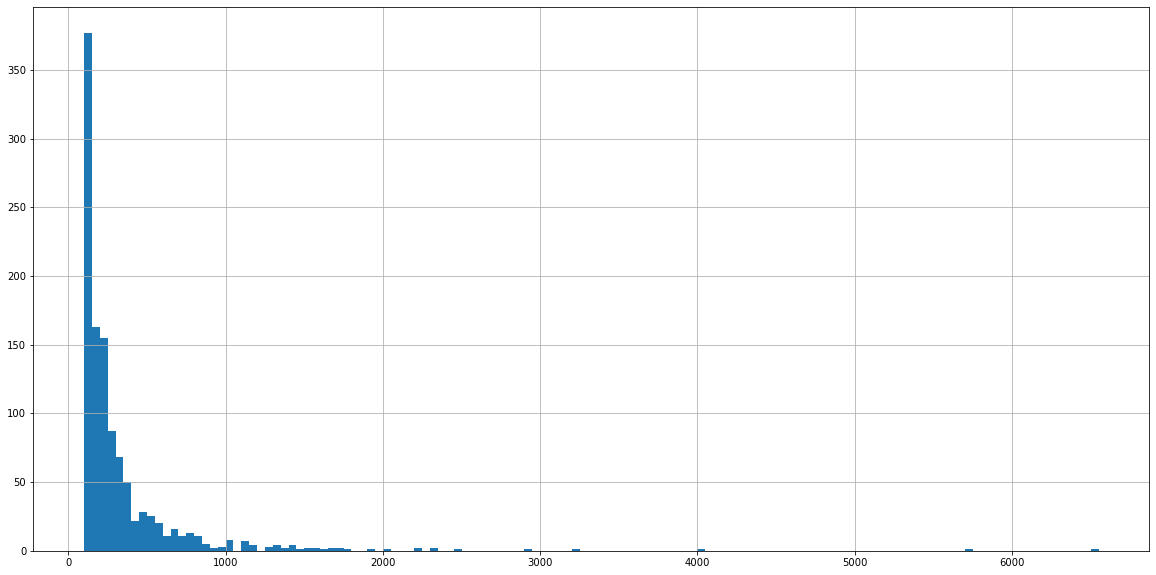

In [32]:
bin_values = np.arange(start=100, stop=6600, step=50)
asin_rev.hist(bins=bin_values, figsize=[20,10])

<AxesSubplot:>

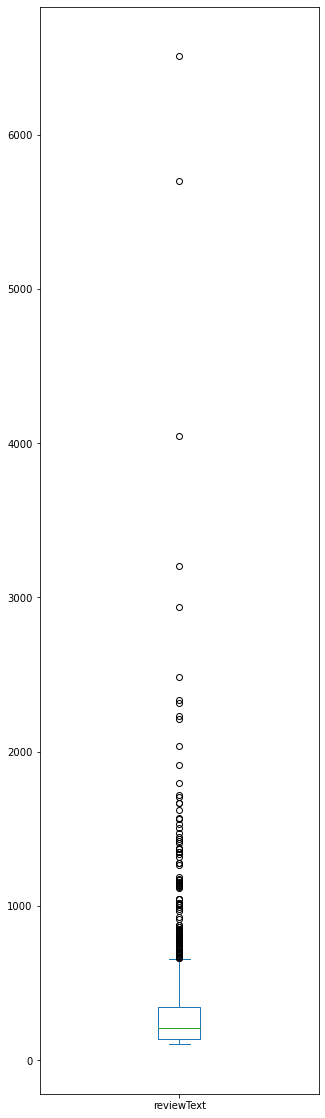

In [33]:
plt.figure(figsize=(5,20))
asin_rev.plot.box()

In [34]:
asin_rev[asin_rev>3000]

asin
B000AST3AK    6510
B0014CN8Y8    4048
B004UB1O9Q    5702
B00KJ07SEM    3200
Name: reviewText, dtype: int64

In [35]:
# asin_sample = data[data['asin'] == 'B000AST3AK'] # GE MWF Refrigerator Water Filter, 1-Pack
# asin_sample = data[data['asin'] == 'B004UB1O9Q'] # Samsung DA29-00020B3 Refrigerator Water Filter
# asin_sample = data[data['asin'] == 'B0014CN8Y8'] # Gardus RLE202 LintEater 10-Piece Rotary Dryer Vent Cleaning System
asin_sample = data[data['asin'] == 'B00KJ07SEM'] # GE MWF SmartWater Compatible Water Filter Cartridge - Refrigerator Water Filter

<AxesSubplot:xlabel='overall'>

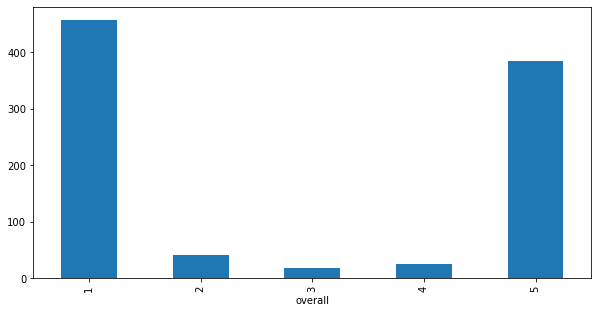

In [36]:
# Number of votes for each category (1 to 5 stars)
votes_sample = asin_sample.groupby(['overall'])['vote'].sum()
plt.figure(figsize=(10,5))
votes_sample.plot.bar()

<AxesSubplot:xlabel='verified', ylabel='Count'>

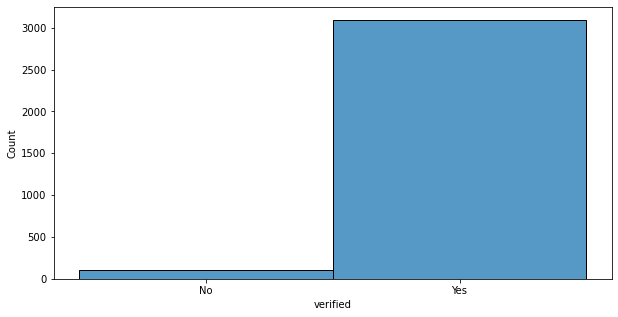

In [37]:
plt.figure(figsize=(10,5))
sns.histplot(asin_sample['verified'],discrete=True)

<AxesSubplot:xlabel='year'>

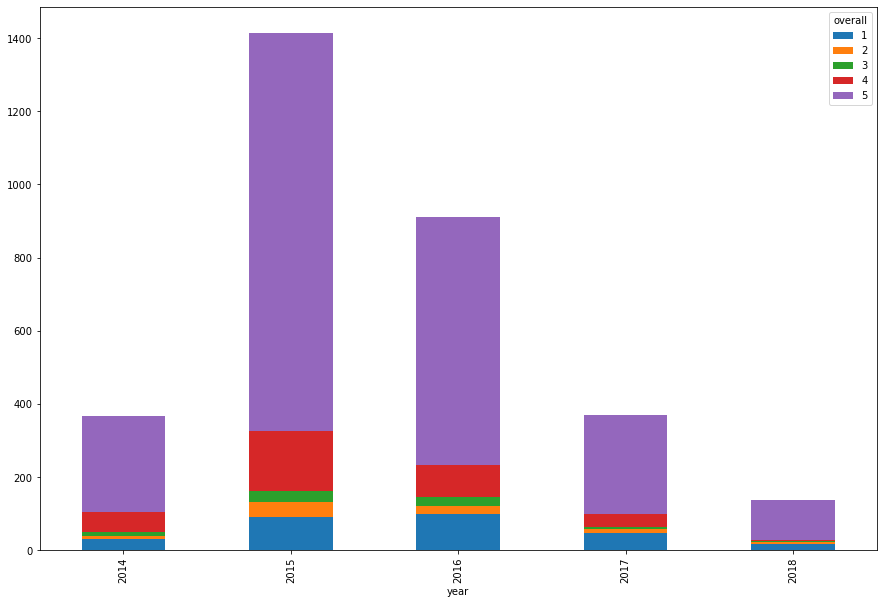

In [38]:
tab_sample = pd.crosstab(asin_sample.year, asin_sample.overall, margins=False, values=asin_sample.overall, aggfunc=pd.Series.count)
tab_sample.plot.bar(stacked=True, figsize=(15,10))

In [39]:
asin_sample_positive = asin_sample[asin_sample['overall'] >= 4]['reviewText']
asin_sample_negative = asin_sample[asin_sample['overall'] < 4]['reviewText']

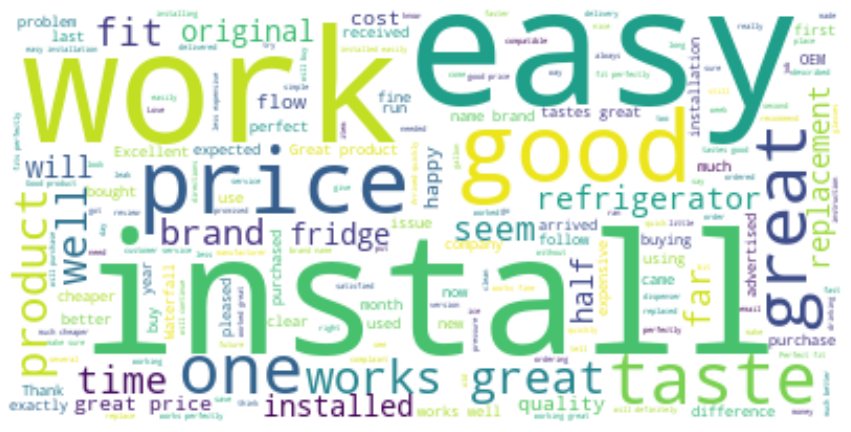

In [40]:
#Cloud word for reviews having more than 4 stars for this asin
text = " ".join(i for i in asin_sample_positive)
stopwords = set(STOPWORDS)
stopwords.add('filter')
stopwords.add('filters')
stopwords.add('amazon')
stopwords.add('water')
stopwords.add('ge')
stopwords.add('mwf')
stopwords.add('samsung')
stopwords.add('gardus')

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

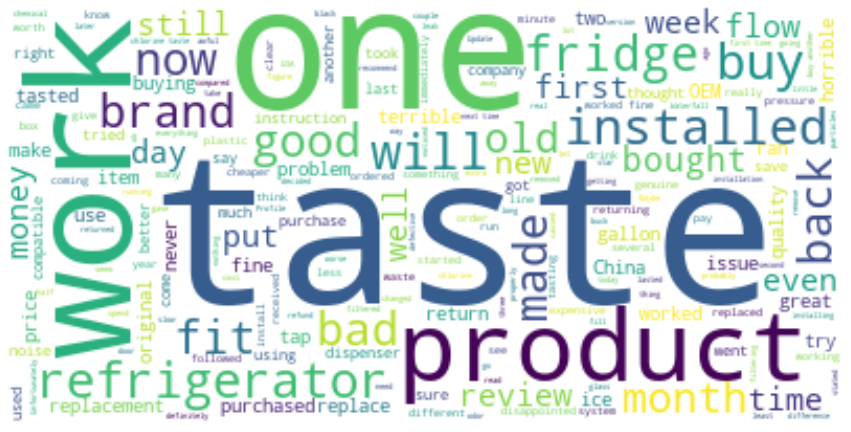

In [41]:
#Cloud word for reviews having less than 4 stars for this asin
text = " ".join(i for i in asin_sample_negative)
stopwords = set(STOPWORDS)
stopwords.add('filter')
stopwords.add('filters')
stopwords.add('amazon')
stopwords.add('water')
stopwords.add('ge')
stopwords.add('mwf')
stopwords.add('samsung')
stopwords.add('gardus')

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
asin_reviews_voted_pos = asin_sample.loc[(asin_sample['vote'] > 50) & (asin_sample['overall'] >=4)]['reviewText']
asin_reviews_voted_neg = asin_sample.loc[(asin_sample['vote'] > 50) & (asin_sample['overall'] < 4)]['reviewText']

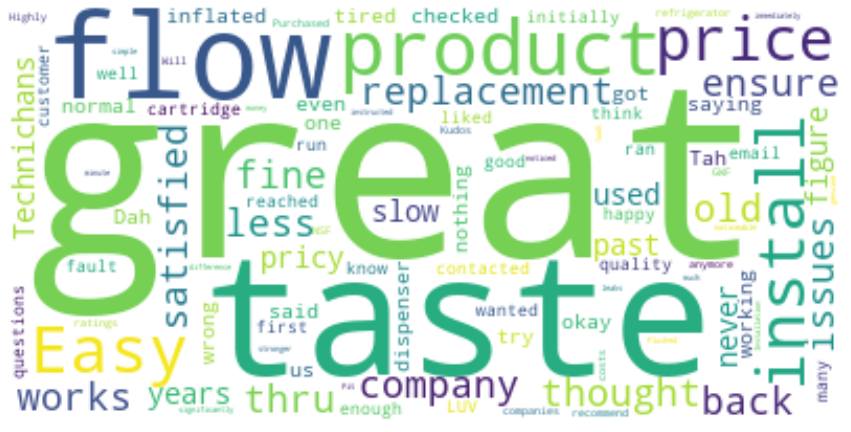

In [43]:
#Cloud word for reviews having more than 4 stars and more than 50 votes for this asin
text = " ".join(i for i in asin_reviews_voted_pos)
stopwords = set(STOPWORDS)
stopwords.add('filter')
stopwords.add('filters')
stopwords.add('amazon')
stopwords.add('water')
stopwords.add('ge')
stopwords.add('mwf')
stopwords.add('samsung')
stopwords.add('gardus')

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

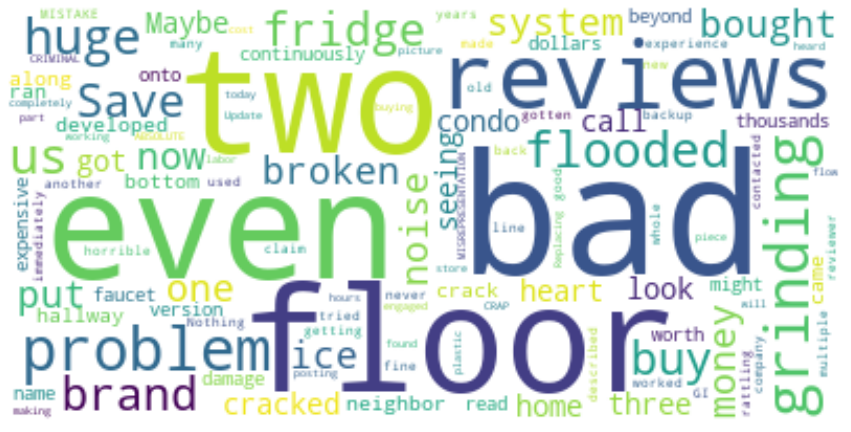

In [44]:
#Cloud word for reviews having more less 4 stars and more than 50 votes for this asin
text = " ".join(i for i in asin_reviews_voted_neg)
stopwords = set(STOPWORDS)
stopwords.add('filter')
stopwords.add('filters')
stopwords.add('amazon')
stopwords.add('water')
stopwords.add('ge')
stopwords.add('mwf')
stopwords.add('samsung')
stopwords.add('gardus')

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Part 2 - Sentimental Model - In progress

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("LiYuan/amazon-review-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("LiYuan/amazon-review-sentiment-analysis")

In [17]:
from time import time
from tqdm import tqdm

In [42]:
dat

,overall,vote,verified,reviewerID,asin,reviewText,summary,unixReviewTime,reviewText_clean,reviewText_deep_clean
58,5,30,No,A2UAX5WTHHKBBF,B00004YWK2,This allows you to switch from venting your dr...,A wonderful idea.,2007-12-09,this allows you to switch from venting your dr...,thi allow switch vent dryer outsid summer vent...
59,3,0,Yes,A2DHQKNGSYEHLS,B00004YWK2,The bands are quite useless.\nThe mesh is not ...,Three Stars,2017-06-06,the bands are quite useless.the mesh is not fi...,the band quit useless the mesh fine enough
60,4,0,Yes,AZ1F62XGI25RS,B00004YWK2,This was just what I was looking for. The serv...,The service and price were very good. It works...,2017-03-14,this was just what i was looking for. the serv...,thi i look the servic price good it work great
61,5,0,Yes,A2G1T9MVZLOHNG,B00004YWK2,Works great!,Five Stars,2017-03-13,works great!,work great
62,5,0,Yes,A17109KS0DCTOG,B00004YWK2,It is a good .put the heat in my house when ne...,It is a good. put the heat in my house when ne...,2017-03-10,it is a good .put the heat in my house when ne...,it good put heat hous need and need
...,...,...,...,...,...,...,...,...,...,...
602714,5,0,Yes,A3KT6VYTFH31SF,B01HICGMWC,"Great price, fit good,and look good.",Filters,2018-09-08,"great price, fit good,and look good.",great price fit goodand look good
602715,5,0,Yes,A2XWTEPQL6FRZQ,B01HICGMWC,this is the first time ordering this filter an...,good filters,2018-09-08,this is the first time ordering this filter an...,first time order filter work great
602716,5,0,Yes,A2NXFZL0HTGJ78,B01HICGMWC,Thank you. Works great.,Thank you,2018-09-03,thank you. works great.,thank work great
602717,5,0,Yes,A2NFUCM454QRF1,B01HICGMWC,Fits great with my Whirlpool refrigerator. Kee...,Highly recommend,2018-08-31,fits great with my whirlpool refrigerator. kee...,fit great whirlpool refriger keep insid smell ...


In [49]:
# Sentiment score calculated usign sentiment_score() function for reviews having more than 250 words, we use chunks to split the 
# text to slices of 250 words each and calculate the sentiment score for each and then apply the average to find the final score 
# of the whole text.
def chunks(xs, n):
    n = max(1, n)
    list_slice = list(xs[i:i+n] for i in range(0, len(xs), n))
    for i in range(len(list_slice)):
        list_slice[i] = ' '.join(list_slice[i])     
    return list_slice

def sentiment_score(text):
    size = 200
    if text.count(" ")+1 < size:          
        tokens = tokenizer.encode(text, return_tensors='pt')
        result = model(tokens)
        return int(torch.argmax(result.logits))+1
    else:
        avg_sent = []
        slicing = chunks(text.split(), size)
        for i in range(len(slicing)):
            tokens = tokenizer.encode(slicing[i], return_tensors='pt')
            result = model(tokens)
            avg_sent.append(int(torch.argmax(result.logits))+1)
        return round(mean(avg_sent))

In [110]:
tst = 'This product will encourage mold in your house!'

In [111]:
sentiment_score(tst)

5

In [69]:
%%time
sentiment_score(asin_sample['reviewText_clean'][602715])

CPU times: total: 359 ms
Wall time: 93.7 ms


5

In [94]:
asin_sample = data[data['asin'] == 'B00KJ07SEM'] 

In [95]:
len(asin_sample)

3200

In [96]:
%%time
score = []
for i in tqdm(asin_sample['reviewText_clean']):
    score.append(sentiment_score(i))

100%|██████████| 3200/3200 [05:41<00:00,  9.36it/s]

CPU times: total: 22min 12s
Wall time: 5min 41s


In [103]:
# asin_sample['Sentiment_Score'] = score
score.count(5)

2643

In [93]:
asin_sample

,overall,vote,verified,reviewerID,asin,reviewText,summary,unixReviewTime,reviewText_clean,reviewText_deep_clean,Sentiment_Score
58,5,30,No,A2UAX5WTHHKBBF,B00004YWK2,This allows you to switch from venting your dr...,A wonderful idea.,2007-12-09,this allows you to switch from venting your dr...,thi allow switch vent dryer outsid summer vent...,5
59,3,0,Yes,A2DHQKNGSYEHLS,B00004YWK2,The bands are quite useless.\nThe mesh is not ...,Three Stars,2017-06-06,the bands are quite useless.the mesh is not fi...,the band quit useless the mesh fine enough,1
60,4,0,Yes,AZ1F62XGI25RS,B00004YWK2,This was just what I was looking for. The serv...,The service and price were very good. It works...,2017-03-14,this was just what i was looking for. the serv...,thi i look the servic price good it work great,5
61,5,0,Yes,A2G1T9MVZLOHNG,B00004YWK2,Works great!,Five Stars,2017-03-13,works great!,work great,5
62,5,0,Yes,A17109KS0DCTOG,B00004YWK2,It is a good .put the heat in my house when ne...,It is a good. put the heat in my house when ne...,2017-03-10,it is a good .put the heat in my house when ne...,it good put heat hous need and need,5
...,...,...,...,...,...,...,...,...,...,...,...
474139,5,0,Yes,A2GFAE3Y6UIT1A,B00004YWK2,Part was as expected and easy to install and w...,Five Stars,2017-12-14,part was as expected and easy to install and w...,part expect easi instal work great,5
474140,1,0,No,A1YJKI6PHXPAJ7,B00004YWK2,This product will encourage mold in your house!,MOLD,2017-12-02,this product will encourage mold in your house!,thi product encourag mold hous,5
474141,5,0,Yes,A3HCE9WN58GVA6,B00004YWK2,I use it with fabric softener and my basement ...,Stop wasting heat in the winter.,2017-11-29,i use it with fabric softener and my basement ...,i use fabric soften basement smell awesom add ...,5
474142,3,0,Yes,A398K8IUQ847ZU,B00004YWK2,I wanted to divert the dryer heat into my shop...,it does the job fine but be advised it is a li...,2017-11-14,i wanted to divert the dryer heat into my shop...,i want divert dryer heat shop back onto hous h...,4


In [50]:
data['asin']

58        B00004YWK2
59        B00004YWK2
60        B00004YWK2
61        B00004YWK2
62        B00004YWK2
             ...    
602714    B01HICGMWC
602715    B01HICGMWC
602716    B01HICGMWC
602717    B01HICGMWC
602718    B01HICGMWC
Name: asin, Length: 368581, dtype: object